In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json

In [29]:
# Settings for the individual figures
FIG_HIGH = 8
FIG_WIDE = 8

TITLE_SIZE = 18
LABEL_SIZE = 14
TICKLABEL_SIZE = 12
TICK_SIZE = 10
ANNOT_SIZE = 8

In [30]:
def get_data() -> np.ndarray:
    '''
    Create some random data for testing, in the actual application this function would read the json file with 5 items
    '''
    file_path = os.path.join('results', 'results.json')
    
    # Check if the file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")

    # Load the JSON file
    with open(file_path, 'r') as json_file:
        x = json.load(json_file)

    # Convert numpy arrays (if any) to lists
    x['cards/'] = np.array(x['cards/']).tolist()
    x['tricks/'] = np.array(x['tricks/']).tolist()
    x['card_ties/'] = np.array(x['card_ties/']).tolist()
    x['trick_ties/'] = np.array(x['trick_ties/']).tolist()

    return x

In [31]:
data = get_data()
data

{'cards/': [[0.0,
   0.5077792220777922,
   0.7064413558644136,
   0.8036736326367363,
   0.9999800019998,
   0.7261343865613439,
   0.9878642135786422,
   0.48605539446055396],
  [0.4725377462253775,
   0.0,
   0.12392860713928606,
   0.036154384561543844,
   0.9976452354764523,
   0.06901109889011099,
   0.47703829617038296,
   0.009501049895010499],
  [0.27725327467253275,
   0.8629177082291771,
   0.0,
   0.4846965303469653,
   0.5575932406759324,
   0.4883831616838316,
   0.9178932106789321,
   0.25240975902409757],
  [0.17632836716328368,
   0.9555274472552745,
   0.4864733526647335,
   0.0,
   0.48625337466253377,
   0.4203059694030597,
   0.0019198080191980803,
   9.99900009999e-06],
  [1.4998500149985002e-05,
   0.0018888111188881112,
   0.4208089191080892,
   0.4847015298470153,
   0.0,
   0.485984401559844,
   0.9555094490550945,
   0.1766873312668733],
  [0.25266773322667735,
   0.9170742925707429,
   0.4875942405759424,
   0.5578002199780022,
   0.48525047495250473,
   0.0

In [32]:
def format_data(array: np.ndarray, countwins= False) -> np.ndarray:
    '''
    Cleans the array of probabilities in decimal form to return whole numbers 
    representing the percent out of 100 and fill the 'nonsense' diagonal with None. 
    The diagonal is filled with None so gray is displayed along the diagonal in the visualization.
    '''
    #takes the original decimal probabilities and puts them in the whole number format of percent and fills the 'nonsense' diagonal

    array = array.astype(float)
    if countwins:
        temp = np.flip((np.round((array)*100,0)),0)
    else:
        temp = np.flip((np.round(array)), 0)
        
    flipped = fill_diag(temp, np.nan)
    return flipped

def fill_diag(array: np.ndarray, filler) -> np.ndarray:
    '''
    Sets the diagonal going up (left to right across) to whatever the user specifies as filler. 
    Done when making annotations (filler = "") and when formatting the data (filler=None)
    '''
    
    flipped = np.flip(array, 0)
    np.fill_diagonal(flipped, filler)
    return np.flip(flipped,0)



def make_annots(wins : np.ndarray,ties: np.ndarray) -> np.ndarray:
    '''
    Uses two 8x8 arrays for wins and ties respectively to return one array of strings in the form win(tie)
    The input arrays will need to already have gone through the format_data function or be in that format already
    '''
    annots = []
    for i in range(8):
        row = []
        for j in range(8):
            row.append(f'{str(wins[i,j])[:-2]} ({str(ties[i,j])[:-2]})')
        annots.append(row)
    annots=fill_diag(annots, "")
    return np.array(annots)

def make_heatmap(data: np.ndarray,
                 annots: np.ndarray,
                 title:str,
                 n: int,
                 hide_y: bool = False,
                 cbar_single: bool = True,
                 ax: plt.Axes = None
                ) -> [plt.Figure, plt.Axes]:
    '''
    If ax is None, create a new figure.
    Otherwise, add the heatmap to the provided ax.
    '''
    
    if ax is None:
        # Create a new figure
        fig, ax = plt.subplots(1, 1, figsize=(FIG_WIDE, FIG_HIGH))
    else:
        # Get the parent figure
        fig = ax.get_figure()

    #seqs= ['BBB','BBR','BRB','BRR','RBB','RBR','RRB','RRR'] #if letters are desired tick labels

    seqs = [f'{i:b}'.zfill(3) for i in range(8)] ##if numbers are desired tick labels

    settings = {
        'vmin': 0,
        'vmax': 100,
        'linewidth': .5,
        'cmap': 'Blues',
        'cbar': False,
        'annot': annots,
        'annot_kws': {"size": ANNOT_SIZE},
        'fmt': ''
    }

    
    sns.heatmap(data=data, ax=ax,  **settings)
    ax.set_xlabel('Me', fontsize=LABEL_SIZE)
    ax.set_ylabel('Opponent', fontsize=LABEL_SIZE)
    ax.set_xticklabels(seqs, fontsize=TICK_SIZE)
    ax.set_yticklabels(seqs[::-1], fontsize=TICK_SIZE)
    ax.set_facecolor('#DBDBDB')

    '''
    If a standalone plot is being created, the colorbar should be adjusted in this make_heatmap function 
    If bundled heatmaps are being made, the colorbar will be adjusted in the make_heatmap_package function to avoid double colorbars
    '''

    if cbar_single: 

        cbar_ax = fig.add_axes([.95, 0.11, 0.035, .77])
        cb = fig.colorbar(ax.collections[0], cax=cbar_ax)
        #adjusting the tickmark sizes on colorbar 
        cb.ax.tick_params(labelsize=TICK_SIZE)
        cb.outline.set_linewidth(.2)

    ax.set_title(title+'\n(n='+str(n)+')', fontsize=TITLE_SIZE)
    
    if hide_y: ### for bundled heatmaps, both the yticks and axis title should be hidden on 2nd subplot
        ax.set_yticks([])
        ax.set_ylabel(None)
     
    return fig, ax


In [33]:
data = get_data()
print("Raw data for card ties:", data['cards/'])

Raw data for card ties: [[0.0, 0.5077792220777922, 0.7064413558644136, 0.8036736326367363, 0.9999800019998, 0.7261343865613439, 0.9878642135786422, 0.48605539446055396], [0.4725377462253775, 0.0, 0.12392860713928606, 0.036154384561543844, 0.9976452354764523, 0.06901109889011099, 0.47703829617038296, 0.009501049895010499], [0.27725327467253275, 0.8629177082291771, 0.0, 0.4846965303469653, 0.5575932406759324, 0.4883831616838316, 0.9178932106789321, 0.25240975902409757], [0.17632836716328368, 0.9555274472552745, 0.4864733526647335, 0.0, 0.48625337466253377, 0.4203059694030597, 0.0019198080191980803, 9.99900009999e-06], [1.4998500149985002e-05, 0.0018888111188881112, 0.4208089191080892, 0.4847015298470153, 0.0, 0.485984401559844, 0.9555094490550945, 0.1766873312668733], [0.25266773322667735, 0.9170742925707429, 0.4875942405759424, 0.5578002199780022, 0.48525047495250473, 0.0, 0.862980701929807, 0.277015298470153], [0.009549045095490451, 0.4786271372862714, 0.06844015598440156, 0.9976232376

In [36]:
data = get_data()

##creating/formatting simulated data for team 1 card_win probabilities and making appropriate annotations 
cards_t1 = format_data(np.array(data['cards/']), countwins=True)
print(cards_t1)
card_ties_t1 = format_data(np.array(data['card_ties/']))  
print(card_ties_t1)
ct1_annots = make_annots(cards_t1, card_ties_t1)
print(ct1_annots)

[[ 49.  99.  73. 100.  80.  71.  51.  nan]
 [  1.  48.   7. 100.   4.  12.  nan  47.]
 [ 25.  92.  49.  56.  49.  nan  86.  28.]
 [  0.   0.  42.  48.  nan  49.  96.  18.]
 [ 18.  96.  49.  nan  49.  42.   0.   0.]
 [ 28.  86.  nan  48.  56.  49.  92.  25.]
 [ 47.  nan  12.   4. 100.   7.  48.   1.]
 [ nan  51.  71.  80. 100.  73.  99.  49.]]
[[2.8821e+04 2.5920e+03 2.1270e+04 5.0000e+00 2.0139e+04 1.6332e+04
  1.9659e+04        nan]
 [2.5870e+03 4.4339e+04 1.3668e+04 4.5700e+02 8.3820e+03 1.3141e+04
         nan 1.9659e+04]
 [2.1200e+04 1.3916e+04 2.4025e+04 2.1896e+04 2.8768e+04        nan
  1.3141e+04 1.6332e+04]
 [5.0000e+00 4.6600e+02 2.1600e+04 2.9048e+04        nan 2.8768e+04
  8.3820e+03 2.0139e+04]
 [2.0000e+04 8.3190e+03 2.8833e+04        nan 2.9048e+04 2.1896e+04
  4.5700e+02 5.0000e+00]
 [1.6307e+04 1.3155e+04        nan 2.8833e+04 2.1600e+04 2.4025e+04
  1.3668e+04 2.1270e+04]
 [1.9685e+04        nan 1.3155e+04 8.3190e+03 4.6600e+02 1.3916e+04
  4.4339e+04 2.5920e+03]
 [  

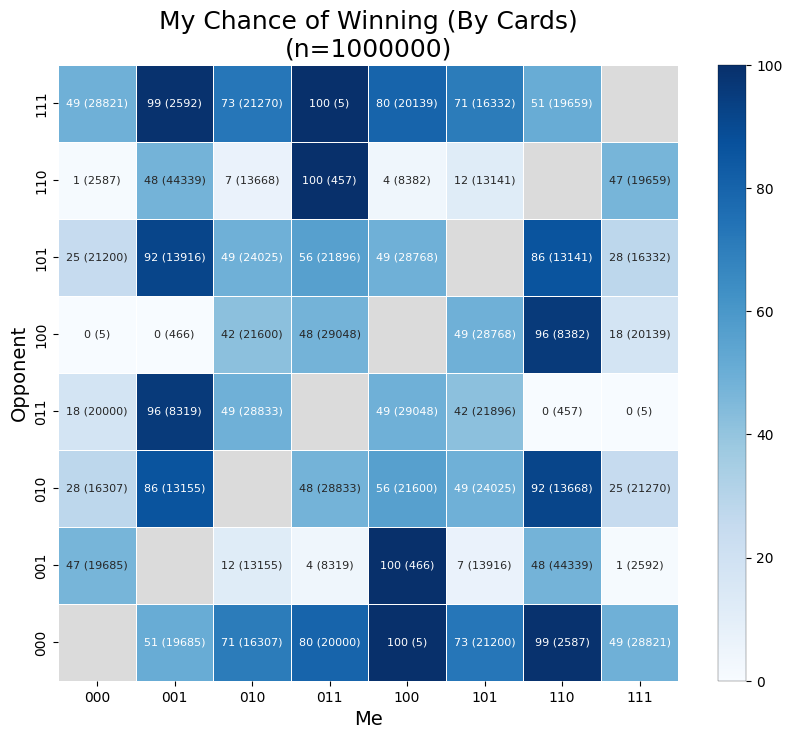

In [37]:
##create a single map for the card_win probabilties
fig1, ax1 = make_heatmap(data=cards_t1, annots=ct1_annots, title="My Chance of Winning (By Cards)", n=1000000)
#fig1.savefig('single_heatmap.png', bbox_inches='tight')